# Setup
This section contains all necessary setup such as libraries and model creation.

In [1]:
import numpy as np

from src.data.data_helper import get_raw_data_as_dataframe

In [2]:
raw_data = get_raw_data_as_dataframe()
raw_data.head()

,time,measurement,label,source
0,0.0000,1.650881,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
1,0.0002,1.654559,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
2,0.0004,1.650881,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
3,0.0006,1.654559,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
4,0.0008,1.654559,0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...


In [3]:
raw_data.shape

(8030000, 4)

## Pre-processor Calibration
Due to the fact that all data needs to be pre-processed using the same bandpass filter and normalization the pre-processor needs to be calibrated. This is done by calculating the coefficients of the bandpass filter and the normalization parameters.

These parameters will then be passed to the selected model class.

In [4]:
from src.models.preprocessing.preprocessor import SignalPreprocessor

pre_processor = SignalPreprocessor(
    low_freq=20.0,
    high_freq=500.0,
    fs=5000.0,
    order=4
)

In [5]:
pre_processor.calibrate(raw_data)

## Data Parsing
This section deals with segmenting the data into usable segements with correct labeling. After that we pre-process the data using the pre-processor which is valibrated above. Once the data is pre-processed we apply one-hot encoding to the labels to allow for the use of F1 score. Finally we split the data into training and validation sets.

In [6]:
from src.data.data_helper import segement_data

In [7]:
segmented_data = segement_data(raw_data, window_length=200*5, overlap=50*5)

In [8]:
segmented_data.head()

,window_data,label,source
0,"[1.6508805694015458, 1.654558881124963, 1.6508...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
1,"[1.6435239459547115, 1.6435239459547115, 1.643...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
2,"[1.6361673225078774, 1.6361673225078774, 1.636...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
3,"[1.647202257678129, 1.647202257678129, 1.65088...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
4,"[1.6435239459547115, 1.6435239459547115, 1.643...",0,C:\Users\erik\IES_codebase\EMG_Project\CDT406-...


In [9]:
segmented_data.iloc[1000]

window_data    [1.952502130721748, 1.952502130721748, 1.94882...
label                                                          2
source         C:\Users\erik\IES_codebase\EMG_Project\CDT406-...
Name: 1000, dtype: object

In [10]:
num_classes = segmented_data['label'].nunique()
num_classes

4

In [11]:
import tensorflow as tf

y_data = np.array(segmented_data['label'].values)
y_data = tf.keras.utils.to_categorical(y_data, num_classes=num_classes)

# I apologize for this horrible line. Can be fixed by fixing the data_helper
X_data = np.stack(segmented_data.drop(columns=['label', 'source'])['window_data'].values)

In [12]:
X_data.shape

(10658, 1000)

In [13]:
X_data = pre_processor.batch_pre_process(X_data)
X_data.shape

(10658, 1000)

In [14]:
y_data.shape

(10658, 4)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
        X_data, y_data, test_size=0.2
    )

In [16]:
X_train.shape

(8526, 1000)

In [17]:
X_val.shape

(2132, 1000)

## Analysis and Fixing of Imblanaces in Labels

In [18]:
label_percentages = segmented_data['label'].value_counts(normalize=True).sort_index() * 100
print(label_percentages)

label
0    55.029086
1     4.325389
2    36.254457
3     4.391068
Name: proportion, dtype: float64


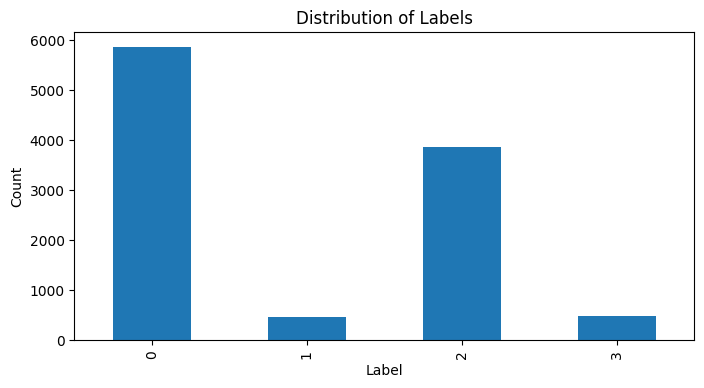

In [19]:
import matplotlib.pyplot as plt

# Plot label distribution
plt.figure(figsize=(8, 4))
segmented_data['label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

## Model Setup
Import model classes and create instances of the models.

In [20]:
from src.models.LSTM.LSTM import LSTM
from src.models.LSTM_STFT.LSTM_STFT import LSTM_STFT
from src.models.LSTM_STFT_Dense.LSTM_STFT_Dense import LSTM_STFT_Dense

In [21]:
LSTM_model = LSTM(input_shape=X_data.shape[1], num_classes=num_classes)

In [22]:
LSTM_STFT_model = LSTM_STFT(input_shape=X_data.shape[1], num_classes=num_classes)

In [23]:
LSTM_STFT_Dense_model = LSTM_STFT_Dense(input_shape=X_data.shape[1], num_classes=num_classes)

# Train Model
Train the models

In [24]:
LSTM_model.train(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=20, verbose=2)

Epoch 1/20
267/267 - 3s - 12ms/step - f1_score: 0.4673 - loss: 0.4324 - val_f1_score: 0.4939 - val_loss: 0.3301
Epoch 2/20
267/267 - 1s - 3ms/step - f1_score: 0.5216 - loss: 0.3458 - val_f1_score: 0.5551 - val_loss: 0.3209
Epoch 3/20
267/267 - 1s - 3ms/step - f1_score: 0.5619 - loss: 0.3341 - val_f1_score: 0.5700 - val_loss: 0.3326
Epoch 4/20
267/267 - 1s - 3ms/step - f1_score: 0.5738 - loss: 0.3258 - val_f1_score: 0.5745 - val_loss: 0.3492
Epoch 5/20
267/267 - 1s - 3ms/step - f1_score: 0.6007 - loss: 0.3237 - val_f1_score: 0.5858 - val_loss: 0.3261
Epoch 6/20
267/267 - 1s - 3ms/step - f1_score: 0.5903 - loss: 0.3205 - val_f1_score: 0.6227 - val_loss: 0.3175
Epoch 7/20
267/267 - 1s - 4ms/step - f1_score: 0.5867 - loss: 0.3244 - val_f1_score: 0.6132 - val_loss: 0.3132
Epoch 8/20
267/267 - 1s - 3ms/step - f1_score: 0.5941 - loss: 0.3166 - val_f1_score: 0.6050 - val_loss: 0.3417
Epoch 9/20
267/267 - 1s - 3ms/step - f1_score: 0.5930 - loss: 0.3173 - val_f1_score: 0.6124 - val_loss: 0.3579


In [25]:
LSTM_STFT_model.train(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=20, verbose=2)

Epoch 1/20
267/267 - 3s - 10ms/step - f1_score: 0.5122 - loss: 0.3793 - val_f1_score: 0.4906 - val_loss: 0.3448
Epoch 2/20
267/267 - 1s - 5ms/step - f1_score: 0.5726 - loss: 0.3213 - val_f1_score: 0.5858 - val_loss: 0.3670
Epoch 3/20
267/267 - 2s - 7ms/step - f1_score: 0.5797 - loss: 0.3215 - val_f1_score: 0.5611 - val_loss: 0.3520
Epoch 4/20
267/267 - 1s - 5ms/step - f1_score: 0.5917 - loss: 0.3165 - val_f1_score: 0.5989 - val_loss: 0.3153
Epoch 5/20
267/267 - 1s - 4ms/step - f1_score: 0.5919 - loss: 0.3137 - val_f1_score: 0.6022 - val_loss: 0.3234
Epoch 6/20
267/267 - 1s - 5ms/step - f1_score: 0.5966 - loss: 0.3160 - val_f1_score: 0.6136 - val_loss: 0.3183
Epoch 7/20
267/267 - 1s - 5ms/step - f1_score: 0.5940 - loss: 0.3150 - val_f1_score: 0.6233 - val_loss: 0.3108
Epoch 8/20
267/267 - 1s - 4ms/step - f1_score: 0.5984 - loss: 0.3120 - val_f1_score: 0.6081 - val_loss: 0.3064
Epoch 9/20
267/267 - 1s - 5ms/step - f1_score: 0.6063 - loss: 0.3081 - val_f1_score: 0.6129 - val_loss: 0.3139


In [26]:
LSTM_STFT_Dense_model.train(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, epochs=20, verbose=2)

Epoch 1/20
267/267 - 5s - 19ms/step - f1_score: 0.4494 - loss: 0.4703 - val_f1_score: 0.4504 - val_loss: 0.4353
Epoch 2/20
267/267 - 2s - 7ms/step - f1_score: 0.4907 - loss: 0.3517 - val_f1_score: 0.5182 - val_loss: 0.3363
Epoch 3/20
267/267 - 2s - 7ms/step - f1_score: 0.5179 - loss: 0.3442 - val_f1_score: 0.4770 - val_loss: 0.3419
Epoch 4/20
267/267 - 2s - 6ms/step - f1_score: 0.5237 - loss: 0.3416 - val_f1_score: 0.5880 - val_loss: 0.3232
Epoch 5/20
267/267 - 2s - 7ms/step - f1_score: 0.5512 - loss: 0.3430 - val_f1_score: 0.5623 - val_loss: 0.3232
Epoch 6/20
267/267 - 1s - 5ms/step - f1_score: 0.5867 - loss: 0.3247 - val_f1_score: 0.5567 - val_loss: 0.3321
Epoch 7/20
267/267 - 1s - 4ms/step - f1_score: 0.5850 - loss: 0.3227 - val_f1_score: 0.6061 - val_loss: 0.3098
Epoch 8/20
267/267 - 1s - 4ms/step - f1_score: 0.5818 - loss: 0.3262 - val_f1_score: 0.6149 - val_loss: 0.3260
Epoch 9/20
267/267 - 1s - 4ms/step - f1_score: 0.5684 - loss: 0.3223 - val_f1_score: 0.6003 - val_loss: 0.3233


# Plotting

In [27]:
from src.visualizations.plot_learning_curves import plot_learning_curves, plot_confusion_and_f1

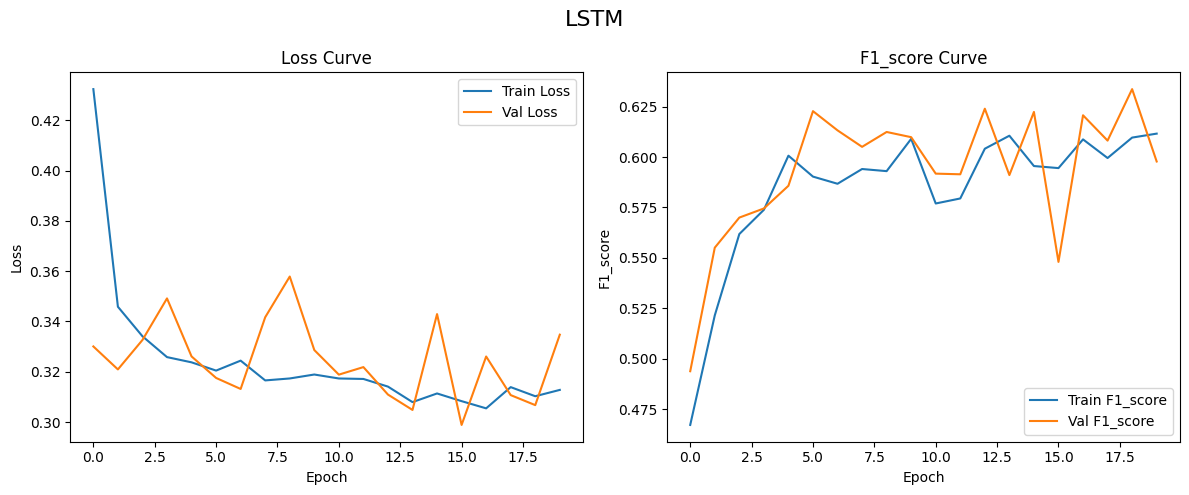

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


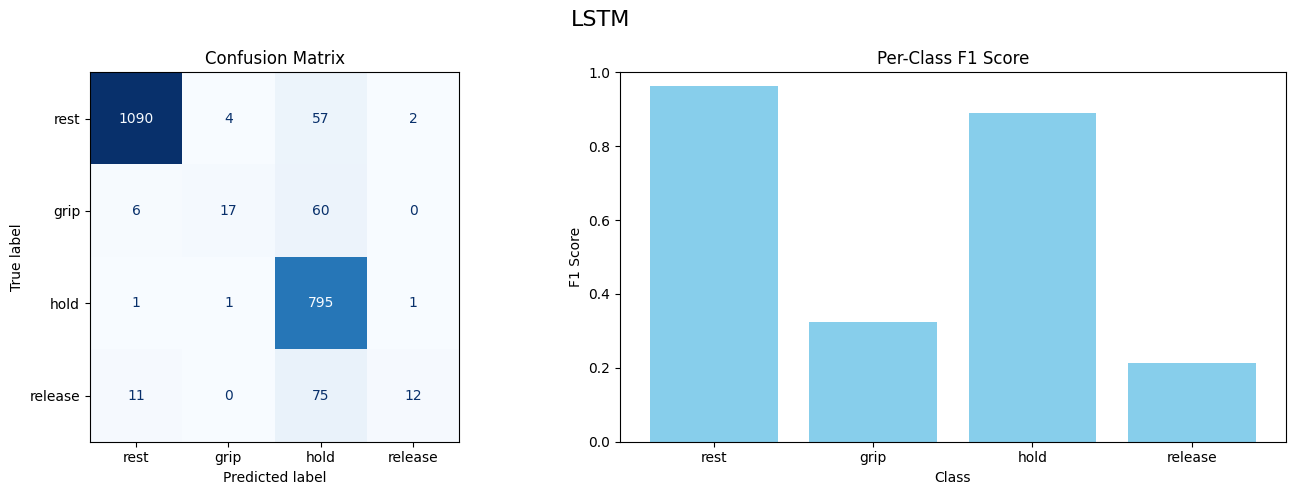

In [28]:
plot_learning_curves(LSTM_model.get_model(), plot_title=LSTM_model.get_model_name())
plot_confusion_and_f1(LSTM_model.get_model(), X_val, y_val, plot_title=LSTM_model.get_model_name())

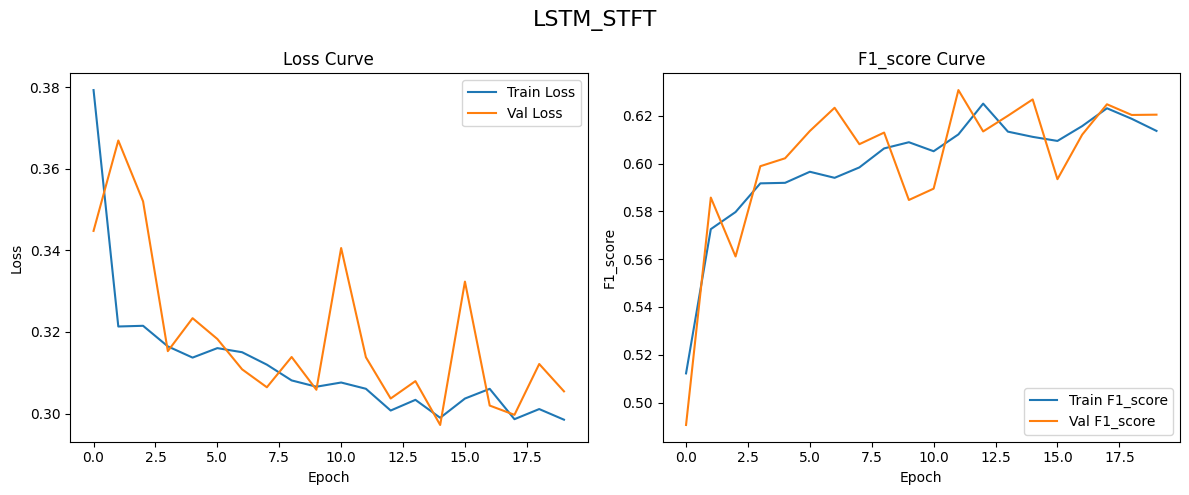

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


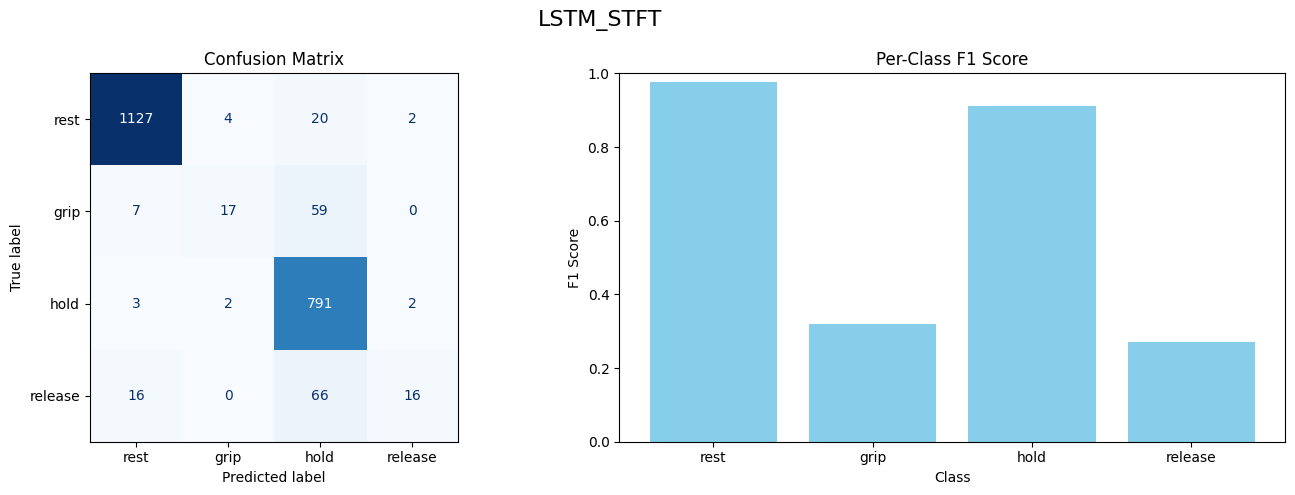

In [29]:
plot_learning_curves(LSTM_STFT_model.get_model(), plot_title=LSTM_STFT_model.get_model_name())
plot_confusion_and_f1(LSTM_STFT_model.get_model(), X_val, y_val, plot_title=LSTM_STFT_model.get_model_name())

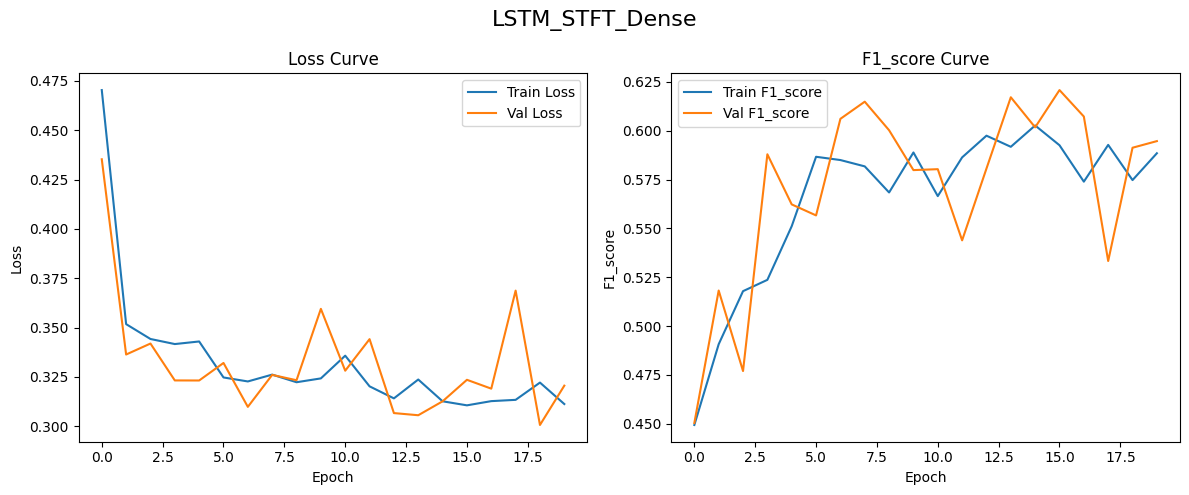

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


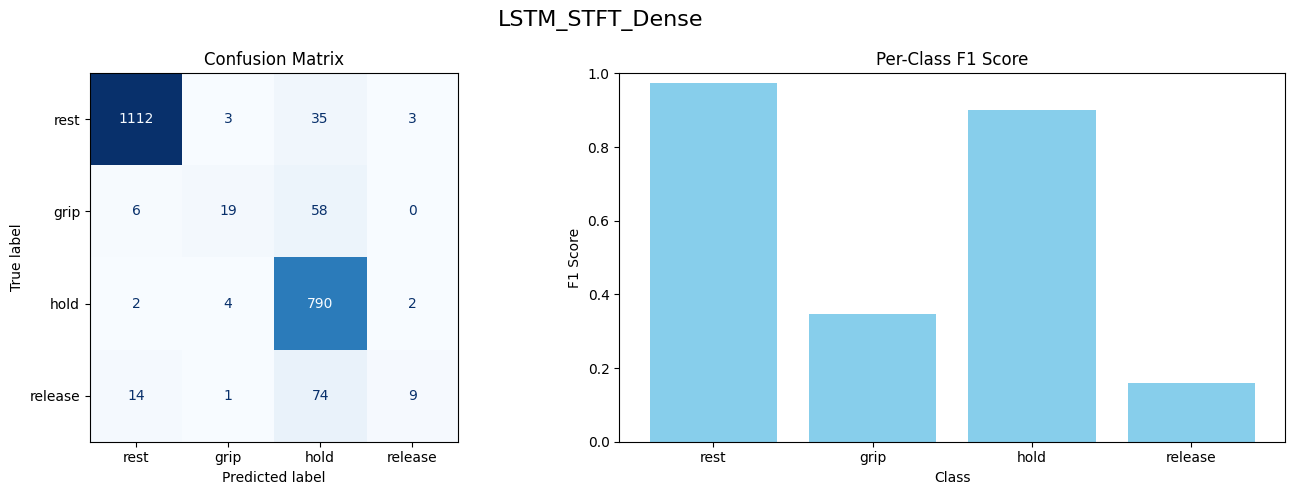

In [30]:
plot_learning_curves(LSTM_STFT_Dense_model.get_model(), plot_title=LSTM_STFT_Dense_model.get_model_name())
plot_confusion_and_f1(LSTM_STFT_Dense_model.get_model(), X_val, y_val, plot_title=LSTM_STFT_Dense_model.get_model_name())